## IMPORT LIBRARIES

In [74]:
import os
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN
import IPython.display as ipd
import json
import pretty_midi
import fluidsynth
from google.cloud import storage
from io import BytesIO
import pickle

## PATH TO SAMPLE, TRAINING AND TEST DATA

In [75]:
MUSIC_TEST_OUTPUT = 'output'
MUSIC_SAMPLE_PATH = 'sample'
JSON_DATA_FILE = 'processed_data.json'
META_DATA_FILE = 'meta_data.json'
BUCKET_NAME = "bucket-piano-data"
MUSIC_TRAIN_PATH = 'gs://{}/train'.format(BUCKET_NAME)
MUSIC_TEST_PATH = 'gs://{}/{}'.format(BUCKET_NAME, META_DATA_FILE)
MUSIC_VALIDATION_PATH = 'gs://{}/validation'.format(BUCKET_NAME)
META_DATA_PATH = 'gs://{}/train'.format(BUCKET_NAME)

## LOAD TRAINING DATA AND PARAMETERS FROM JSON FILE

In [76]:
storage_client = storage.Client()
bucket = storage_client.get_bucket('bucket-piano-data')

In [77]:
blob = bucket.get_blob('meta_data.json') 
meta_data = json.loads(blob.download_as_string())

In [79]:
blob = bucket.get_blob('maestro-v3.0.0.json') 
file_data = json.loads(blob.download_as_string())

In [80]:
train_notes_to_token = meta_data['notes_to_tokens_dict']
train_token_to_notes = meta_data['tokens_to_notes_dict']

In [81]:
class CustomDataGenerator(keras.utils.Sequence):
    def __init__(self, prefix, bucket, meta_data=meta_data, batch_size=BATCH_SIZE):
        self.prefix = prefix
        self.bucket = bucket
        self.batch_size = batch_size
        self.meta_data = meta_data
        self.num_samples = len(list(bucket.list_blobs(prefix=self.prefix)))
        
    def __len__(self):
        return (np.ceil(self.num_samples / float(self.batch_size))).astype(np.int)
    
    def convert_label_to_one_hot(self, output_labels):
        output_one_hot = []
        for sample in range(output_labels.shape[0]):
            sample_output = output_labels[sample,:]
            sample_output_one_hot = np.zeros((sample_output.size, sample_output.max()+1))
            sample_output_one_hot[np.arange(sample_output.size), sample_output] = 1
            output_one_hot.append(sample_output_one_hot)

        return np.array(output_one_hot)
    
    def __getitem__(self, idx):
        batch_x = []
        batch_y = []
        start_idx = self.batch_size * idx
        for blob in bucket.list_blobs(prefix=self.prefix)[start_idx:start_idx+self.batch_size]:
            json_data = json.loads(json.loads(blob.download_as_string()))
            batch_x.append(json_data['input'])
            batch_y.append(json_data['output'])
        return np.array(batch_x), self.convert_label_to_one_hot(batch_y)

In [82]:
training_batch_generator = CustomDataGenerator('train', bucket)
validation_batch_generator = CustomDataGenerator('validation', bucket)

## MODEL PARAMETERS

In [83]:
NUM_UNIQUE_NOTES = meta_data['num_unique_notes']
KEY_FPS = meta_data['key_fps']
HOP_LENGTH = meta_data['hop_length']
WINDOW_SIZE_IN_KEYS = meta_data['windows_size_in_keys']
SAMPLE_RATE = KEY_FPS * HOP_LENGTH
FRAME_SIZE = WINDOW_SIZE_IN_KEYS * HOP_LENGTH
MAX_PIANO_FREQ = meta_data['max_piano_freq']
SEQ_DURATION_SECS = meta_data['seq_length_in_mins']*60

## GET FILENAMES

In [108]:
def get_file_names(file_data, bucket, instance_type='train', seq_length=SEQ_DURATION_SECS):
    file_names = []
    for file_id in file_data['split']:
        if file_data['split'][file_id] == instance_type:
            for i in range((np.ceil(file_data['duration'][file_id] / float(SEQ_DURATION_SECS))).astype(np.int)):
                file_name = file_id+'_'+str(i)+'.json'
                file_path = instance_type+'/'+file_name
                blob = bucket.get_blob(file_name)
                if blob is not None:
                    file_names.append(file_name)
    return file_names

In [ ]:
train_file_names = get_file_names(file_data, bucket, 'train', SEQ_DURATION_SECS)
test_file_names = get_file_names(file_data, bucket, 'test', SEQ_DURATION_SECS)
validation_file_names = get_file_names(file_data, bucket, 'validation', SEQ_DURATION_SECS)

In [103]:
print(len(train_file_names))
print(len(test_file_names))
print(len(validation_file_names))

0
0
0


## A SINGLE BASIC RNN CELL

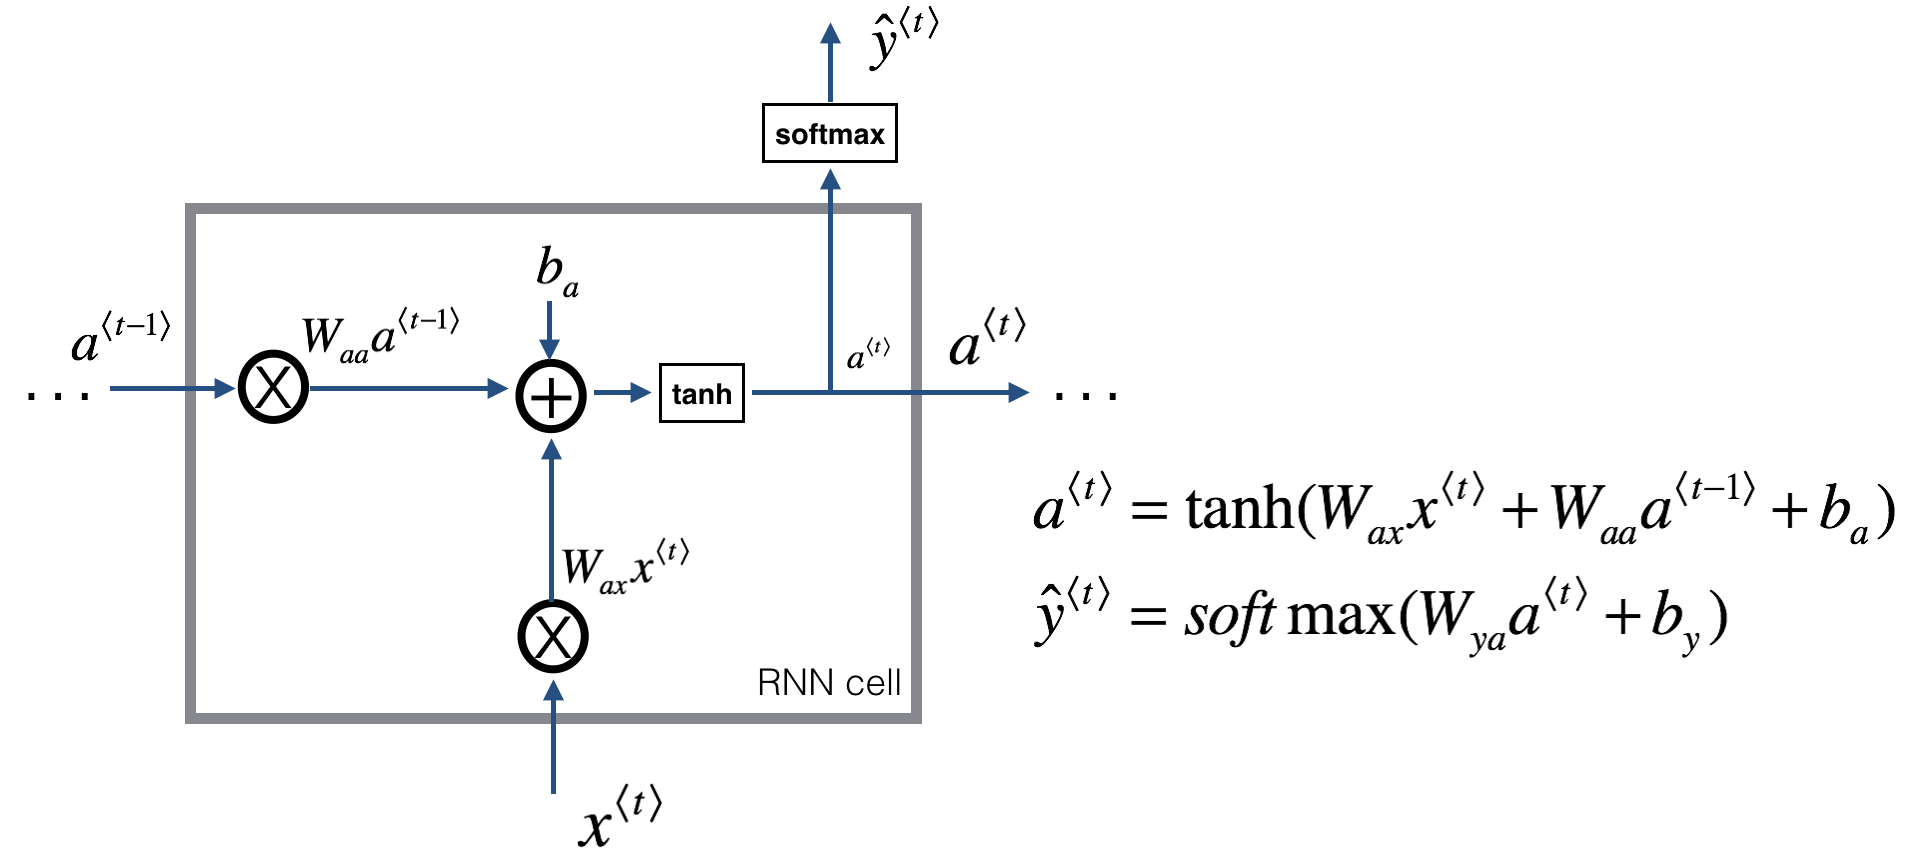

In [41]:
ipd.Image("images/rnn_vanilla.png")

## SPECIFY MODEL ARCHITECTURE

In [42]:
model = Sequential()
model.add(SimpleRNN(RNN_CELL_SIZE, activation='relu', return_sequences=True, input_shape=(None, MAX_PIANO_FREQ), stateful=True,
                   batch_input_shape=(BATCH_SIZE, None, MAX_PIANO_FREQ)))
# model.add(Dropout(DROPOUT_RATE))
model.add(Dense(NUM_UNIQUE_NOTES, activation='softmax'))
model.build()
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 simple_rnn_3 (SimpleRNN)    (32, None, 128)           278656    
                                                                 
 dense_3 (Dense)             (32, None, 623198)        80392542  
                                                                 
Total params: 80,671,198
Trainable params: 80,671,198
Non-trainable params: 0
_________________________________________________________________


## CHOOSE OPTIMIZER AND COMPILE MODEL

In [43]:
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE, decay=DECAY_RATE)
model.compile(loss=LOSS_FN, optimizer=optimizer, metrics=METRICS)

## TRAIN MODEL

In [44]:
model.fit_generator(generator=training_batch_generator, epochs=NUM_EPOCHS, validation_data=validation_batch_generator)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  """Entry point for launching an IPython kernel.


TypeError: 'HTTPIterator' object is not subscriptable

## EVALUATE MODEL AND MAKE PREDICTION

In [ ]:
scores = model.evaluate(X_test, y_test, verbose=0)
print("Accuracy on test data: %.2f%%" % (scores[1]*100))

In [ ]:
y_predict = model.predict(X_test)
print(y_predict.shape)

## CONVERT PREDICTION TO MIDI

In [ ]:
def convert_prediction_to_midi(indx, output, token_to_notes=test_token_to_notes, note_vel_mean_var=test_note_velocity_mean_var):
    assert (output.shape[-1] == NUM_UNIQUE_NOTES)
    notes_seq = [token_to_notes[str(x)] for x in output.argmax(1)]
    instrument = pretty_midi.Instrument(0, name='piano')
    note_details = {}
    pm = pretty_midi.PrettyMIDI()
    
    for index, note in enumerate(notes_seq):
        if note != '':
            notes = note.split(',')
            for i in notes:
                note_vel = np.random.normal(note_vel_mean_var[indx][0][int(i)], note_vel_mean_var[indx][1][int(i)])
                if int(i) not in note_details:
                    note_details[int(i)]=[[index], [index], [note_vel]]
                else:
                    if note_details[int(i)][1][-1]==(index-1):
                        note_details[int(i)][1][-1]=index
                    else:
                        note_details[int(i)][0].append(index)
                        note_details[int(i)][1].append(index)
                        note_details[int(i)][2].append(note_vel)

    for note in note_details:
        for start_time, end_time, note_velocity in zip(note_details[note][0], note_details[note][1], note_details[note][2]):
            pretty_note = pretty_midi.Note(
                velocity=int(note_velocity),
                pitch=note,
                start=start_time/KEY_FPS,
                end=end_time/KEY_FPS
            )
            instrument.notes.append(pretty_note)
    
    instrument.notes.sort(key=lambda x: x.start)
    pm.instruments.append(instrument)
    return pm

In [ ]:
file_indx = 0
pmidi = convert_prediction_to_midi(file_indx, y_predict[file_indx])
pmidi.write(os.path.join(MUSIC_TEST_OUTPUT, test_data['filenames'][file_indx]+'.midi'))